In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from PIL import Image
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import zipfile

import torch.nn.functional as F
from rich.console import Console
from rich.progress import Progress, BarColumn, TimeElapsedColumn, TimeRemainingColumn
from rich.table import Table

import pandas as pd
from torch.cuda.amp import autocast, GradScaler


from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix
import seaborn as sns
import numpy as np

In [2]:
# Install Git in case it's not available in your environment
!apt-get install git

# Clone the repository from GitHub
!git clone https://github.com/Samin1362/MerakiNexus-V2.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Cloning into 'MerakiNexus-V2'...
remote: Enumerating objects: 6353, done.
remote: Counting objects: 100% (422/422), done.
remote: Compressing objects: 100% (394/394), done.
remote: Total 6353 (delta 37), reused 393 (delta 28), pack-reused 5931 (from 1)
Receiving objects: 100% (6353/6353), 1.60 GiB | 44.16 MiB/s, done.
Resolving deltas: 100% (60/60), done.
Updating files: 100% (6223/6223), done.


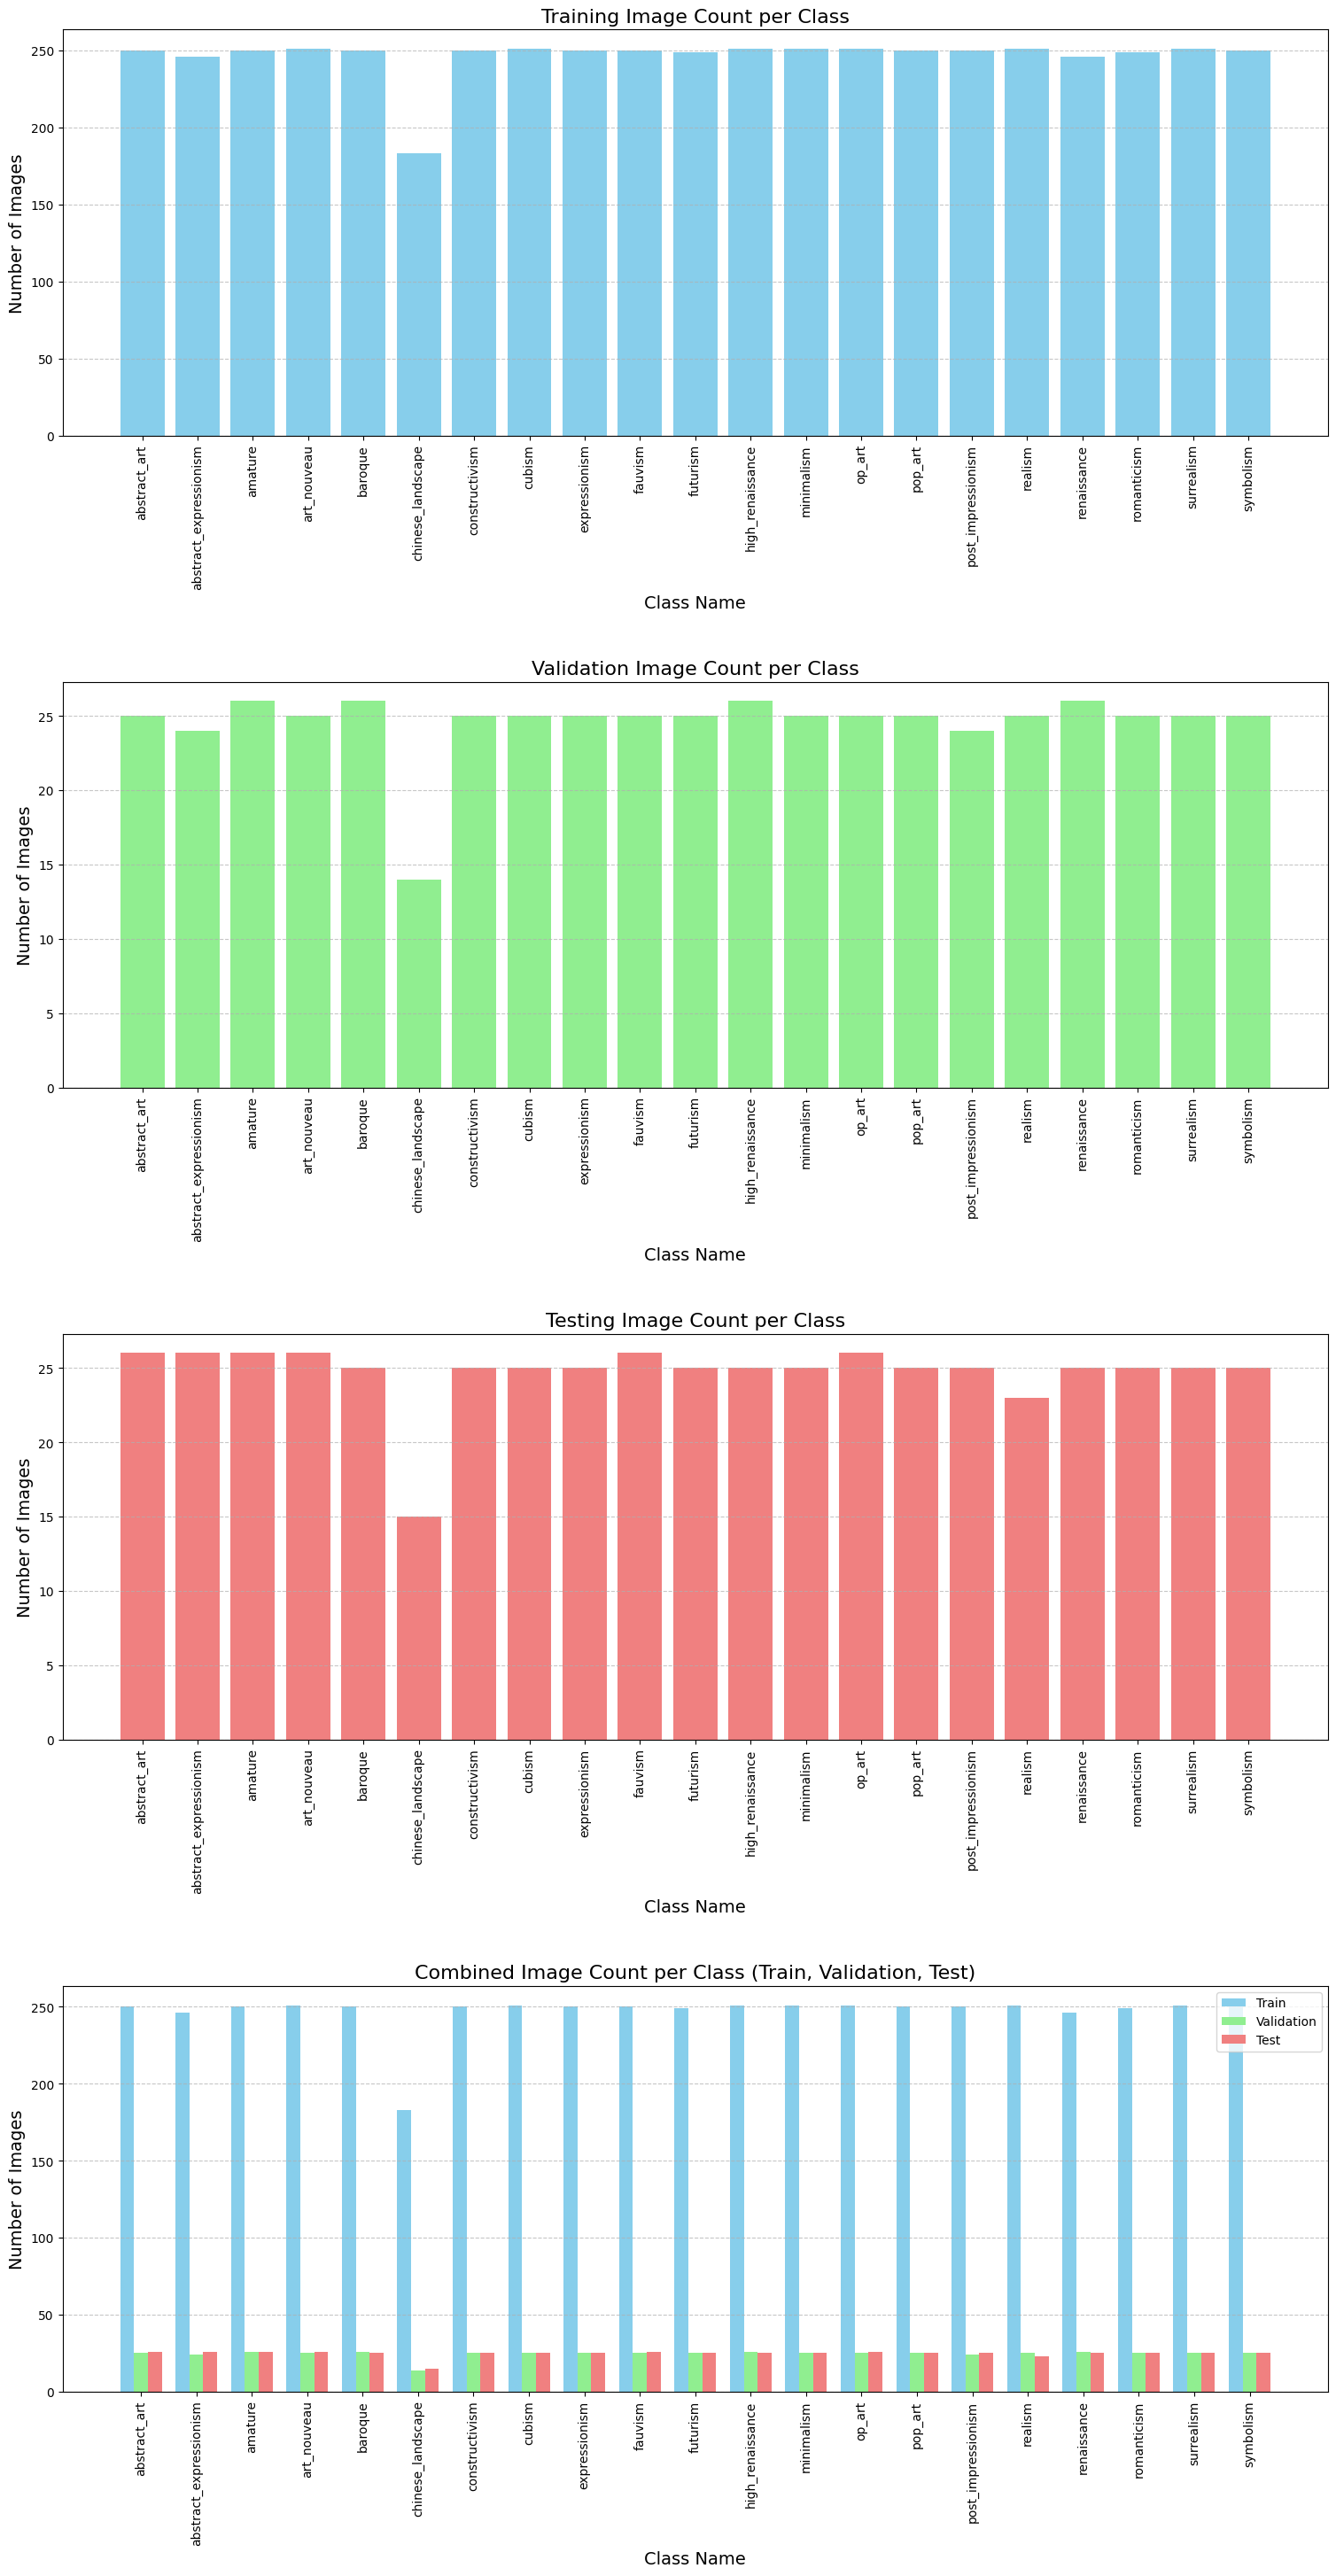

In [3]:
import os
import matplotlib.pyplot as plt
from torchvision import datasets

# Define dataset path
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"  # Update path if needed

# Load datasets
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train")
val_dataset = datasets.ImageFolder(root=f"{dataset_path}/val")
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test")

# Get class names and initialize counters
class_names = train_dataset.classes
train_image_counts, val_image_counts, test_image_counts = [], [], []

# Count images per class
for class_name in class_names:
    train_count = len(os.listdir(os.path.join(train_dataset.root, class_name)))
    val_count = len(os.listdir(os.path.join(val_dataset.root, class_name)))
    test_count = len(os.listdir(os.path.join(test_dataset.root, class_name)))

    train_image_counts.append(train_count)
    val_image_counts.append(val_count)
    test_image_counts.append(test_count)

# Create vertically stacked subplots
fig, axes = plt.subplots(4, 1, figsize=(16, 30))  # Wider + taller for readability

# Common x-axis style
def style_x_axis(ax):
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=90, fontsize=10)
    ax.set_xlabel("Class Name", fontsize=14)
    ax.set_ylabel("Number of Images", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Training set plot
axes[0].bar(range(len(class_names)), train_image_counts, color='skyblue')
axes[0].set_title('Training Image Count per Class', fontsize=16)
style_x_axis(axes[0])

# Validation set plot
axes[1].bar(range(len(class_names)), val_image_counts, color='lightgreen')
axes[1].set_title('Validation Image Count per Class', fontsize=16)
style_x_axis(axes[1])

# Test set plot
axes[2].bar(range(len(class_names)), test_image_counts, color='lightcoral')
axes[2].set_title('Testing Image Count per Class', fontsize=16)
style_x_axis(axes[2])

# Combined view with grouped bars
bar_width = 0.25
x = list(range(len(class_names)))

axes[3].bar([i - bar_width for i in x], train_image_counts, width=bar_width, label='Train', color='skyblue')
axes[3].bar(x, val_image_counts, width=bar_width, label='Validation', color='lightgreen')
axes[3].bar([i + bar_width for i in x], test_image_counts, width=bar_width, label='Test', color='lightcoral')

axes[3].set_title('Combined Image Count per Class (Train, Validation, Test)', fontsize=16)
axes[3].set_xticks(x)
axes[3].set_xticklabels(class_names, rotation=90, fontsize=10)
axes[3].set_xlabel("Class Name", fontsize=14)
axes[3].set_ylabel("Number of Images", fontsize=14)
axes[3].legend()
axes[3].grid(axis='y', linestyle='--', alpha=0.7)

# Final layout adjustments
plt.tight_layout(pad=4)
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 134MB/s]
Epoch 1/10 Training: 100%|██████████| 162/162 [01:26<00:00,  1.87it/s, loss=1.3]


Epoch 1 Loss: 1.5707 | Train Acc: 53.62% | Val Acc: 55.08%


Epoch 2/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.237]


Epoch 2 Loss: 0.6302 | Train Acc: 80.50% | Val Acc: 61.33%


Epoch 3/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.516]


Epoch 3 Loss: 0.2705 | Train Acc: 92.12% | Val Acc: 63.48%


Epoch 4/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.198]


Epoch 4 Loss: 0.1698 | Train Acc: 95.38% | Val Acc: 60.74%


Epoch 5/10 Training: 100%|██████████| 162/162 [01:34<00:00,  1.71it/s, loss=0.357]


Epoch 5 Loss: 0.0966 | Train Acc: 97.48% | Val Acc: 63.48%


Epoch 6/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.78it/s, loss=0.288]


Epoch 6 Loss: 0.0749 | Train Acc: 98.08% | Val Acc: 65.43%


Epoch 7/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=0.318]


Epoch 7 Loss: 0.1165 | Train Acc: 96.48% | Val Acc: 64.84%


Epoch 8/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.80it/s, loss=0.0728]


Epoch 8 Loss: 0.0692 | Train Acc: 98.16% | Val Acc: 62.89%


Epoch 9/10 Training: 100%|██████████| 162/162 [01:29<00:00,  1.80it/s, loss=0.0403]


Epoch 9 Loss: 0.0716 | Train Acc: 97.95% | Val Acc: 59.77%


Epoch 10/10 Training: 100%|██████████| 162/162 [01:30<00:00,  1.79it/s, loss=0.0959]


Epoch 10 Loss: 0.0953 | Train Acc: 97.04% | Val Acc: 62.11%

Total Training Time: 952.43s (15.87min)


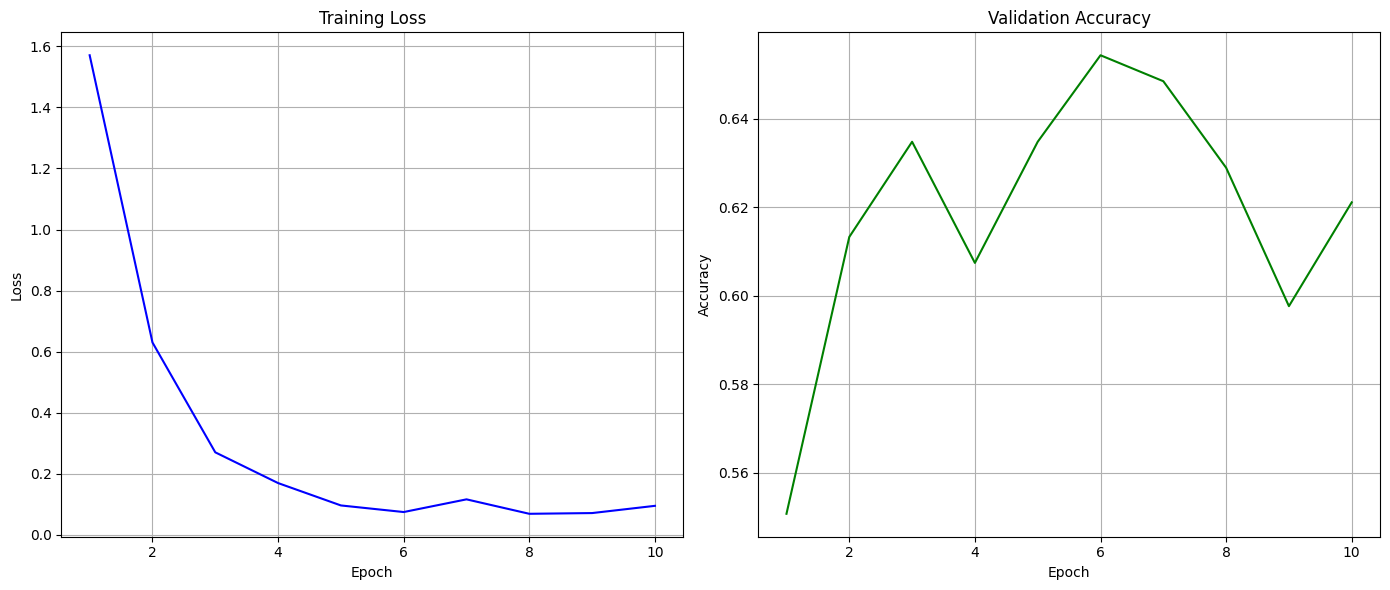


Test Accuracy: 63.01%

Classification Report:

                        precision    recall  f1-score   support

          abstract_art       0.30      0.24      0.27        25
abstract_expressionism       0.71      0.60      0.65        25
               amature       1.00      0.68      0.81        25
           art_nouveau       0.67      0.48      0.56        25
               baroque       0.53      0.88      0.66        24
     chinese_landscape       0.82      1.00      0.90        14
        constructivism       0.80      0.48      0.60        25
                cubism       0.84      0.64      0.73        25
         expressionism       0.88      0.56      0.68        25
               fauvism       0.38      0.60      0.47        25
              futurism       0.53      0.76      0.62        25
      high_renaissance       0.74      0.56      0.64        25
            minimalism       0.76      0.88      0.81        25
                op_art       0.66      0.84      0.74  

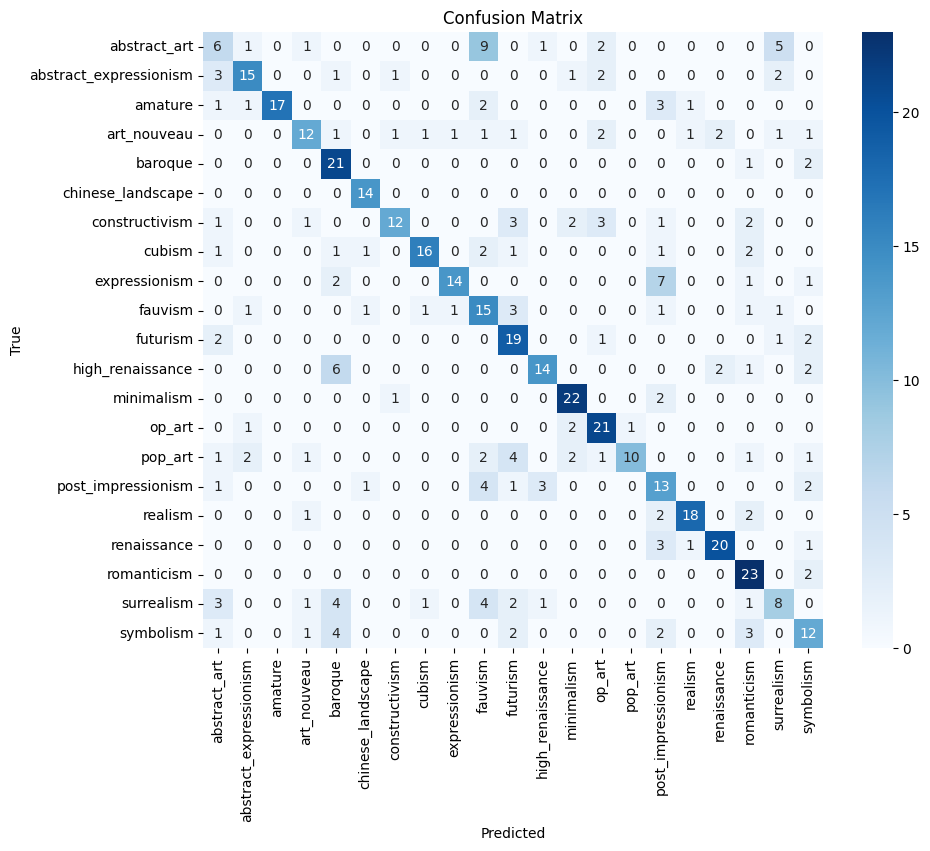

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx  # Return label as integer

# Define model
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Paths
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Initialize model
model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tepoch.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy*100:.2f}% | Val Acc: {val_accuracy*100:.2f}%")

# Training time
total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# =======================
# Evaluation on Test Set
# =======================
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy & Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.4MB/s]
Epoch 1/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.61it/s, loss=2.15]


Epoch 1 Loss: 2.4942 | Train Acc: 33.22% | Val Acc: 47.46%


Epoch 2/25 Training: 100%|██████████| 162/162 [01:03<00:00,  2.54it/s, loss=0.855]


Epoch 2 Loss: 1.4307 | Train Acc: 61.36% | Val Acc: 56.25%


Epoch 3/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.58it/s, loss=0.885]


Epoch 3 Loss: 0.9329 | Train Acc: 73.10% | Val Acc: 59.18%


Epoch 4/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s, loss=0.783]


Epoch 4 Loss: 0.6520 | Train Acc: 80.55% | Val Acc: 62.30%


Epoch 5/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s, loss=0.39]


Epoch 5 Loss: 0.4535 | Train Acc: 87.00% | Val Acc: 64.06%


Epoch 6/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.65it/s, loss=0.145]


Epoch 6 Loss: 0.3152 | Train Acc: 91.49% | Val Acc: 63.28%


Epoch 7/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.65it/s, loss=0.271]


Epoch 7 Loss: 0.2199 | Train Acc: 94.47% | Val Acc: 64.65%


Epoch 8/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.235]


Epoch 8 Loss: 0.1846 | Train Acc: 94.78% | Val Acc: 65.43%


Epoch 9/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.203]


Epoch 9 Loss: 0.1340 | Train Acc: 96.40% | Val Acc: 65.04%


Epoch 10/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.168]


Epoch 10 Loss: 0.1226 | Train Acc: 96.98% | Val Acc: 66.60%


Epoch 11/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.159]


Epoch 11 Loss: 0.1046 | Train Acc: 97.12% | Val Acc: 67.38%


Epoch 12/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s, loss=0.0447]


Epoch 12 Loss: 0.0878 | Train Acc: 97.66% | Val Acc: 66.80%


Epoch 13/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.156]


Epoch 13 Loss: 0.0739 | Train Acc: 97.95% | Val Acc: 66.99%


Epoch 14/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.0264]


Epoch 14 Loss: 0.0734 | Train Acc: 97.95% | Val Acc: 66.02%


Epoch 15/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.0906]


Epoch 15 Loss: 0.0699 | Train Acc: 97.99% | Val Acc: 64.65%


Epoch 16/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.0398]


Epoch 16 Loss: 0.0468 | Train Acc: 98.82% | Val Acc: 67.38%


Epoch 17/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.036]


Epoch 17 Loss: 0.0532 | Train Acc: 98.55% | Val Acc: 66.80%


Epoch 18/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.112]


Epoch 18 Loss: 0.0445 | Train Acc: 98.80% | Val Acc: 67.77%


Epoch 19/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.0673]


Epoch 19 Loss: 0.0361 | Train Acc: 99.17% | Val Acc: 65.82%


Epoch 20/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.0523]


Epoch 20 Loss: 0.0398 | Train Acc: 98.90% | Val Acc: 66.21%


Epoch 21/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.62it/s, loss=0.0747]


Epoch 21 Loss: 0.0472 | Train Acc: 98.65% | Val Acc: 66.41%


Epoch 22/25 Training: 100%|██████████| 162/162 [01:02<00:00,  2.61it/s, loss=0.0522]


Epoch 22 Loss: 0.0471 | Train Acc: 98.70% | Val Acc: 64.84%


Epoch 23/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.63it/s, loss=0.444]


Epoch 23 Loss: 0.0410 | Train Acc: 98.74% | Val Acc: 65.43%


Epoch 24/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.61it/s, loss=0.0801]


Epoch 24 Loss: 0.0366 | Train Acc: 99.03% | Val Acc: 66.80%


Epoch 25/25 Training: 100%|██████████| 162/162 [01:01<00:00,  2.64it/s, loss=0.0797]


Epoch 25 Loss: 0.0340 | Train Acc: 99.01% | Val Acc: 66.99%

Total Training Time: 1646.19s (27.44min)


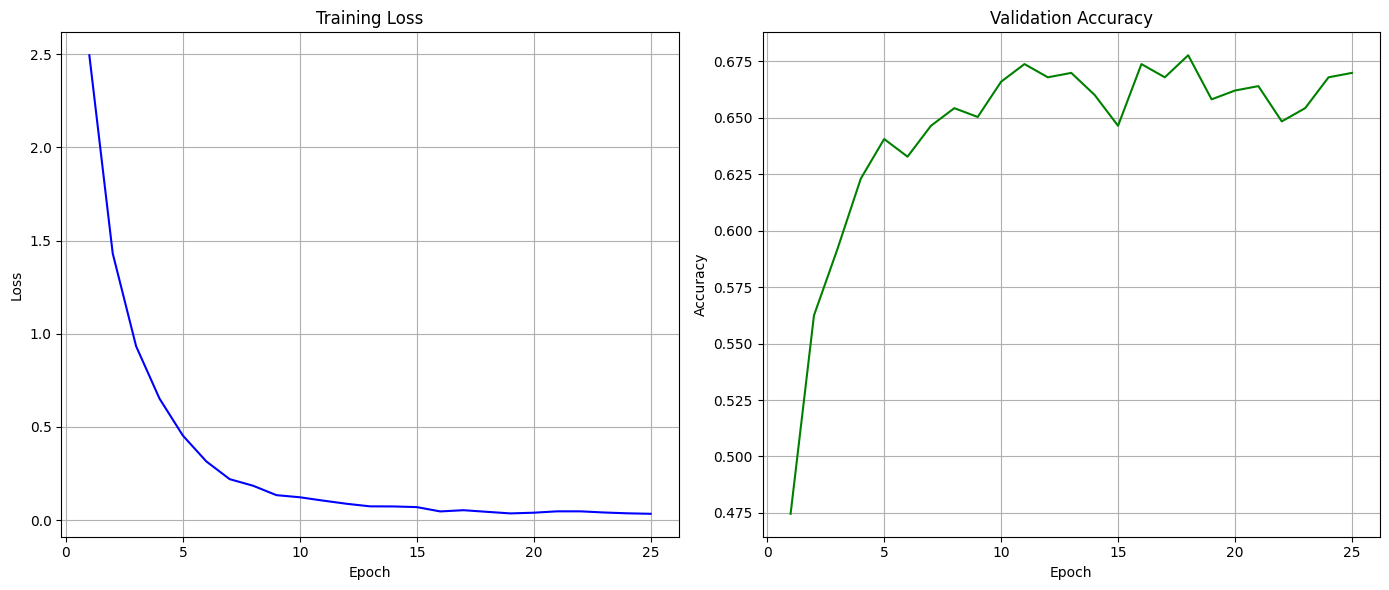


Test Accuracy: 65.56%

Classification Report:

                        precision    recall  f1-score   support

          abstract_art       0.64      0.36      0.46        25
abstract_expressionism       0.70      0.56      0.62        25
               amature       0.95      0.84      0.89        25
           art_nouveau       0.62      0.52      0.57        25
               baroque       0.68      0.88      0.76        24
     chinese_landscape       0.58      1.00      0.74        14
        constructivism       0.47      0.64      0.54        25
                cubism       0.82      0.72      0.77        25
         expressionism       0.76      0.76      0.76        25
               fauvism       0.48      0.48      0.48        25
              futurism       0.49      0.84      0.62        25
      high_renaissance       0.71      0.60      0.65        25
            minimalism       0.61      0.80      0.69        25
                op_art       0.62      0.52      0.57  

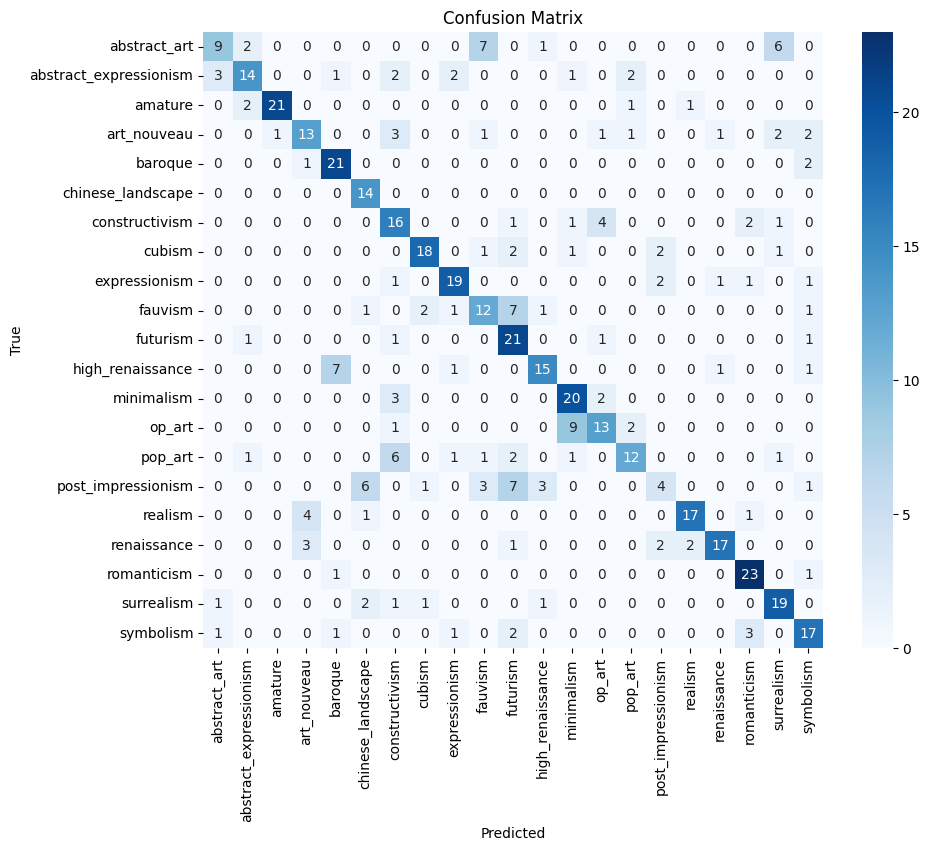

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# EfficientNet-based model
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=11):
        super(ArtworkClassificationModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet prefers 224x224 input for b0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Model, Loss, Optimizer
model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 25
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            tepoch.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy*100:.2f}% | Val Acc: {val_accuracy*100:.2f}%")

# Training time
total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [7]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_efficientNet.pth");

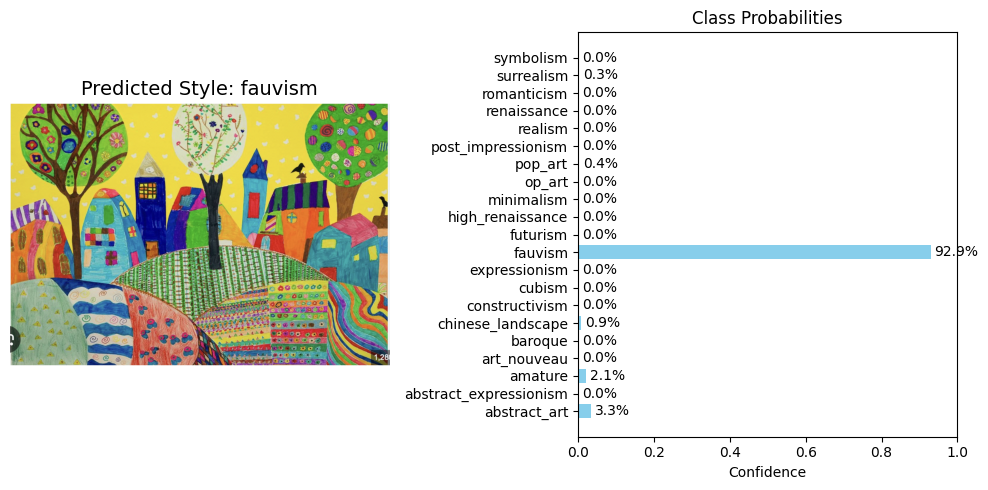

In [13]:
scripted_model = torch.jit.load("/content/artwork_classification_model_efficientNet.pth")
scripted_model.eval()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet prefers 224x224 input for b0
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

# --- Visualize prediction for a single image ---
def predict_single_image(image_path, model, transform, class_names):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Set model to evaluation mode and make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class_idx = output.argmax(dim=1).item()
        predicted_class = class_names[predicted_class_idx]
        probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]

    # Visualization
    plt.figure(figsize=(10, 5))

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted Style: {predicted_class}", fontsize=14)
    plt.axis("off")

    # Show prediction confidence for each class
    plt.subplot(1, 2, 2)
    bars = plt.barh(class_names, probabilities, color='skyblue')
    plt.xlabel("Confidence")
    plt.title("Class Probabilities")
    plt.xlim([0, 1])
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{bar.get_width()*100:.1f}%", va='center')
    plt.tight_layout()
    plt.show()

# Example usage
test_image_path = "10.png"  # change this to your test image
predict_single_image(test_image_path, scripted_model, transform, train_data.classes)


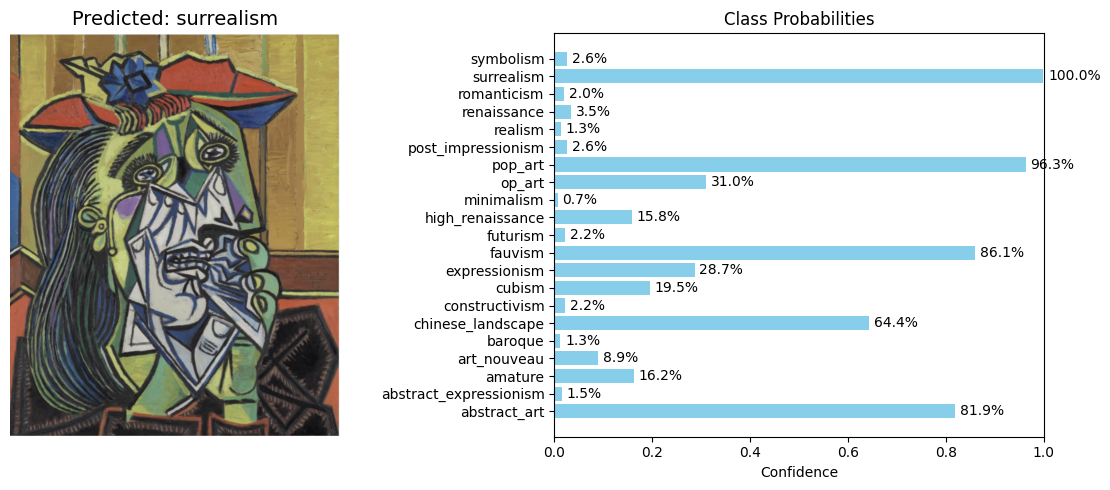

Market Value Score: 0.0000


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Define weights for known art styles (based on your value model)
art_style_weights = {
    "Abstract Expressionism": 100,
    "Pop Art": 95,
    "Baroque": 90,
    "Renaissance": 85,
    "Cubism": 80,
    "Surrealism": 75,
    "Art Nouveau": 70,
    "Minimalism": 65,
    "Expressionism": 60,
    "Futurism": 55,
    "High Renaissance": 50,
    "Romanticism": 45,
    "Realism": 40,
    "Symbolism": 35,
    "Constructivism": 30,
    "Op Art": 25,
    "Art Deco": 20,
    "Chinese Landscape": 15,
    "Post-Impressionism": 10,
    "Abstract Art": 0,
    "Neo-Classicism": 5  # Ensure total 21 classes
}

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the scripted model
scripted_model = torch.jit.load("/content/artwork_classification_model_efficientNet.pth")
scripted_model.to(device)
scripted_model.eval()

# Define transform (EfficientNet-B0 size & normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset class to help extract classes
class CustomArtworkDataset(datasets.ImageFolder):
    def __init__(self, root_dir, transform=None):
        super().__init__(root_dir, transform=transform)

    def __getitem__(self, idx):
        img_path, class_idx = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Load dataset (only to get class names)
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root_dir=f"{dataset_path}/train", transform=transform)
class_names = train_data.classes  # Get class names from training data (21 classes)

# Build weights list dynamically aligned with class_names
weights_list = [art_style_weights.get(cls, 0) for cls in class_names]

# Prediction + visualization function
def predict_single_image(image_path, model, transform, class_names, weights_list):
    # Load and transform the image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.sigmoid(output).cpu().numpy()[0]

        # Check length consistency
        if len(probabilities) != len(class_names):
            raise ValueError(f"Model output ({len(probabilities)}) and class names ({len(class_names)}) mismatch!")

        # Calculate weighted market value
        weighted_sum = sum(probabilities[i] * weights_list[i] for i in range(len(class_names)))
        total_weight = sum(weights_list)
        market_value = weighted_sum / total_weight if total_weight > 0 else 0

        # Visualization
        plt.figure(figsize=(12, 5))

        # Show image
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Predicted: {class_names[np.argmax(probabilities)]}", fontsize=14)
        plt.axis("off")

        # Show probabilities
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_names, probabilities, color='skyblue')
        plt.xlabel("Confidence")
        plt.title("Class Probabilities")
        plt.xlim([0, 1])
        for bar in bars:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                     f"{bar.get_width()*100:.1f}%", va='center')
        plt.tight_layout()
        plt.show()

        return market_value

# Test on image
test_image_path = "1.png"  # Ensure this image is in working directory
market_value_score = predict_single_image(test_image_path, scripted_model, transform, class_names, weights_list)
print(f"Market Value Score: {market_value_score:.4f}")


Probabilities after Softmax: [3.3337481e-02 1.2333588e-05 2.0911593e-02 4.3855666e-04 8.8243718e-07
 8.9680227e-03 9.4240440e-06 1.4527274e-04 1.7566716e-05 9.2900729e-01
 1.2096419e-05 2.8573369e-05 1.2507925e-05 1.0953475e-05 3.8223134e-03
 1.2150366e-05 3.5394823e-05 3.4464487e-05 7.3708907e-06 3.1676290e-03
 8.0374293e-06]
Predicted Class: fauvism with Probability: 0.9290072917938232
Class: abstract_art, Probability: 0.033337, Weight: 0, Weighted Value: 0.000000
Class: abstract_expressionism, Probability: 0.000012, Weight: 100, Weighted Value: 0.001233
Class: amature, Probability: 0.020912, Weight: 0, Weighted Value: 0.000000
Class: art_nouveau, Probability: 0.000439, Weight: 70, Weighted Value: 0.030699
Class: baroque, Probability: 0.000001, Weight: 90, Weighted Value: 0.000079
Class: chinese_landscape, Probability: 0.008968, Weight: 15, Weighted Value: 0.134520
Class: constructivism, Probability: 0.000009, Weight: 30, Weighted Value: 0.000283
Class: cubism, Probability: 0.000145,

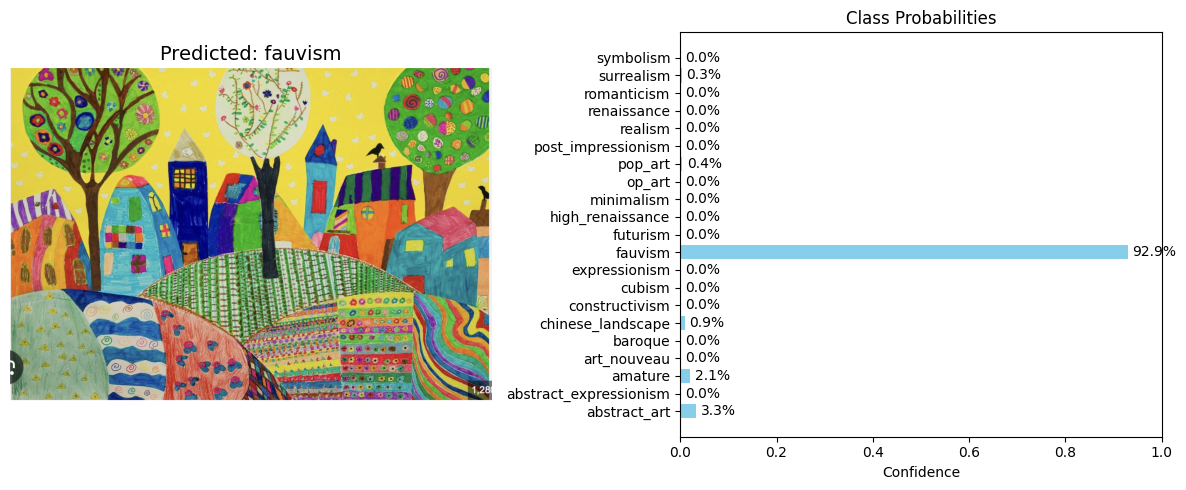

Market Value Score: 5.43%


In [18]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define style weights (21 total classes)
art_style_weights = {
    "abstract_expressionism": 100,
    "pop_art": 95,
    "baroque": 90,
    "renaissance": 85,
    "cubism": 80,
    "surrealism": 75,
    "art_nauveau": 70,
    "art_nouveau": 70,
    "minimalism": 65,
    "expressionism": 60,
    "futurism": 55,
    "high_renaissance": 50,
    "romanticism": 45,
    "realism": 40,
    "symbolism": 35,
    "chinese_landscape": 15,
    "constructivism": 30,
    "op_art": 25,
    "post_impressionism": 10,
    "fauvism": 5,
    "abstract_art": 0
}

# Load scripted model
scripted_model = torch.jit.load("/content/artwork_classification_model_efficientNet.pth")
scripted_model.to(device)
scripted_model.eval()

# Transforms for EfficientNet input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset to get class names
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Load training data to get class names
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)  # Fixed here, using `root`
class_names = train_data.classes
weights_list = [art_style_weights.get(cls, 0) for cls in class_names]

# Prediction function
def predict_single_image(image_path, model, transform, class_names, weights_list):
    try:
        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Predict with softmax for multi-class classification
        with torch.no_grad():
            output = model(image_tensor)

            # Apply softmax to get probabilities
            probabilities = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]
            print(f"Probabilities after Softmax: {probabilities}")

        # Get predicted class
        predicted_class_idx = np.argmax(probabilities)
        predicted_class = class_names[predicted_class_idx]

        # Debug print the class and corresponding probability
        print(f"Predicted Class: {predicted_class} with Probability: {probabilities[predicted_class_idx]}")

        # Calculate weighted market value
        weighted_sum = 0
        for idx, class_name in enumerate(class_names):
            class_weight = art_style_weights.get(class_name, 0)
            weighted_value = probabilities[idx] * class_weight
            weighted_sum += weighted_value

            # Debug: Print weighted sum calculation
            print(f"Class: {class_name}, Probability: {probabilities[idx]:.6f}, Weight: {class_weight}, Weighted Value: {weighted_value:.6f}")

        # total_weight = sum(weights_list)
        total_weight = 100;
        market_value = (weighted_sum / total_weight) * 100 if total_weight > 0 else 0  # Convert to percentage

        # Debug prints for market value calculation
        print(f"\nTotal Weighted Sum: {weighted_sum:.6f}")
        print(f"Total Weight: {total_weight}")
        print(f"Market Value Score (Percentage): {market_value:.2f}%")

        # Visualization
        plt.figure(figsize=(12, 5))

        # Image display
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Predicted: {predicted_class}", fontsize=14)
        plt.axis("off")

        # Confidence scores
        plt.subplot(1, 2, 2)
        bars = plt.barh(class_names, probabilities, color='skyblue')
        plt.xlabel("Confidence")
        plt.title("Class Probabilities")
        plt.xlim([0, 1])
        for bar in bars:
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                     f"{bar.get_width()*100:.1f}%", va='center')
        plt.tight_layout()
        plt.show()

        return market_value

    except Exception as e:
        print("Error during prediction:", e)
        return 0

# Example usage
test_image_path = "10.png"  # Make sure this image exists
market_value_score = predict_single_image(test_image_path, scripted_model, transform, class_names, weights_list)

print(f"Market Value Score: {market_value_score:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/101M [00:00<?, ?B/s]

Epoch 1/25 Training: 100%|██████████| 646/646 [02:21<00:00,  4.57it/s, loss=0.946]


Epoch 1 Loss: 1.5100 | Train Acc: 52.73% | Val Acc: 52.93%


Epoch 2/25 Training: 100%|██████████| 646/646 [02:25<00:00,  4.46it/s, loss=0.543]


Epoch 2 Loss: 0.5608 | Train Acc: 82.31% | Val Acc: 59.18%


Epoch 3/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.478]


Epoch 3 Loss: 0.2183 | Train Acc: 92.82% | Val Acc: 64.26%


Epoch 4/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.421]


Epoch 4 Loss: 0.1300 | Train Acc: 95.76% | Val Acc: 60.55%


Epoch 5/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.0853]


Epoch 5 Loss: 0.1153 | Train Acc: 96.09% | Val Acc: 62.50%


Epoch 6/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.111]


Epoch 6 Loss: 0.1148 | Train Acc: 96.65% | Val Acc: 66.99%


Epoch 7/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.0884]


Epoch 7 Loss: 0.0759 | Train Acc: 98.03% | Val Acc: 58.40%


Epoch 8/25 Training: 100%|██████████| 646/646 [02:29<00:00,  4.33it/s, loss=0.0562]


Epoch 8 Loss: 0.1129 | Train Acc: 96.61% | Val Acc: 61.52%


Epoch 9/25 Training: 100%|██████████| 646/646 [02:29<00:00,  4.32it/s, loss=0.000287]


Epoch 9 Loss: 0.0655 | Train Acc: 98.12% | Val Acc: 64.06%


Epoch 10/25 Training: 100%|██████████| 646/646 [02:28<00:00,  4.36it/s, loss=0.264]


Epoch 10 Loss: 0.0746 | Train Acc: 97.81% | Val Acc: 53.52%


Epoch 11/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.138]


Epoch 11 Loss: 0.0848 | Train Acc: 97.37% | Val Acc: 56.84%


Epoch 12/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.0307]


Epoch 12 Loss: 0.0714 | Train Acc: 97.91% | Val Acc: 65.23%


Epoch 13/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.39it/s, loss=0.000518]


Epoch 13 Loss: 0.0768 | Train Acc: 97.85% | Val Acc: 64.26%


Epoch 14/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.0276]


Epoch 14 Loss: 0.0453 | Train Acc: 98.65% | Val Acc: 64.65%


Epoch 15/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.0129]


Epoch 15 Loss: 0.0538 | Train Acc: 98.37% | Val Acc: 65.23%


Epoch 16/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.145]


Epoch 16 Loss: 0.0701 | Train Acc: 97.89% | Val Acc: 65.82%


Epoch 17/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.084]


Epoch 17 Loss: 0.0627 | Train Acc: 98.05% | Val Acc: 63.28%


Epoch 18/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.0501]


Epoch 18 Loss: 0.0240 | Train Acc: 99.32% | Val Acc: 61.33%


Epoch 19/25 Training: 100%|██████████| 646/646 [02:27<00:00,  4.39it/s, loss=0.0109]


Epoch 19 Loss: 0.0699 | Train Acc: 98.08% | Val Acc: 64.84%


Epoch 20/25 Training: 100%|██████████| 646/646 [02:27<00:00,  4.39it/s, loss=0.0115]


Epoch 20 Loss: 0.0676 | Train Acc: 97.89% | Val Acc: 61.52%


Epoch 21/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.0215]


Epoch 21 Loss: 0.0471 | Train Acc: 98.47% | Val Acc: 62.70%


Epoch 22/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.41it/s, loss=0.00295]


Epoch 22 Loss: 0.0301 | Train Acc: 99.11% | Val Acc: 64.84%


Epoch 23/25 Training: 100%|██████████| 646/646 [02:27<00:00,  4.38it/s, loss=0.225]


Epoch 23 Loss: 0.0542 | Train Acc: 98.55% | Val Acc: 60.16%


Epoch 24/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.213]


Epoch 24 Loss: 0.0412 | Train Acc: 98.92% | Val Acc: 53.91%


Epoch 25/25 Training: 100%|██████████| 646/646 [02:26<00:00,  4.40it/s, loss=0.0015]


Epoch 25 Loss: 0.0606 | Train Acc: 98.08% | Val Acc: 63.28%

Total Training Time: 3804.95s (63.42min)


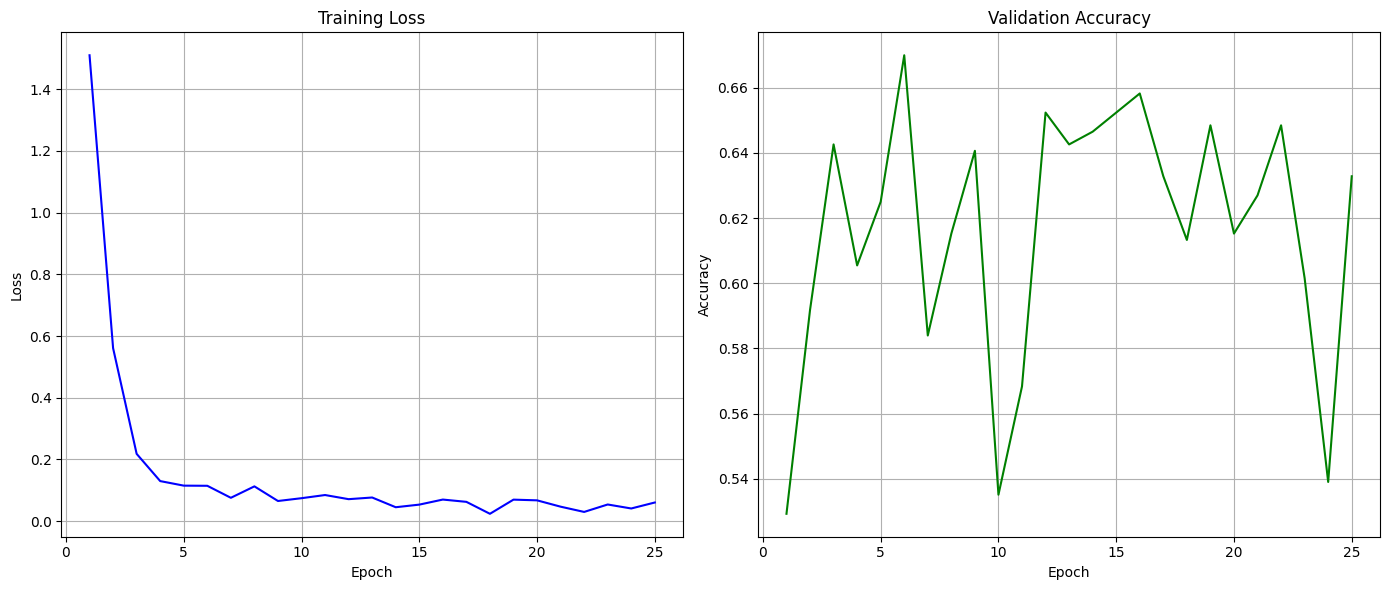


Test Accuracy: 63.41%

Classification Report:

                        precision    recall  f1-score   support

          abstract_art       0.50      0.40      0.44        25
abstract_expressionism       0.75      0.36      0.49        25
               amature       1.00      0.68      0.81        25
           art_nouveau       0.50      0.36      0.42        25
               baroque       0.69      0.75      0.72        24
     chinese_landscape       0.67      1.00      0.80        14
        constructivism       0.50      0.68      0.58        25
                cubism       0.54      0.76      0.63        25
         expressionism       0.75      0.72      0.73        25
               fauvism       0.38      0.40      0.39        25
              futurism       0.53      0.72      0.61        25
      high_renaissance       0.83      0.60      0.70        25
            minimalism       0.77      0.80      0.78        25
                op_art       0.68      0.76      0.72  

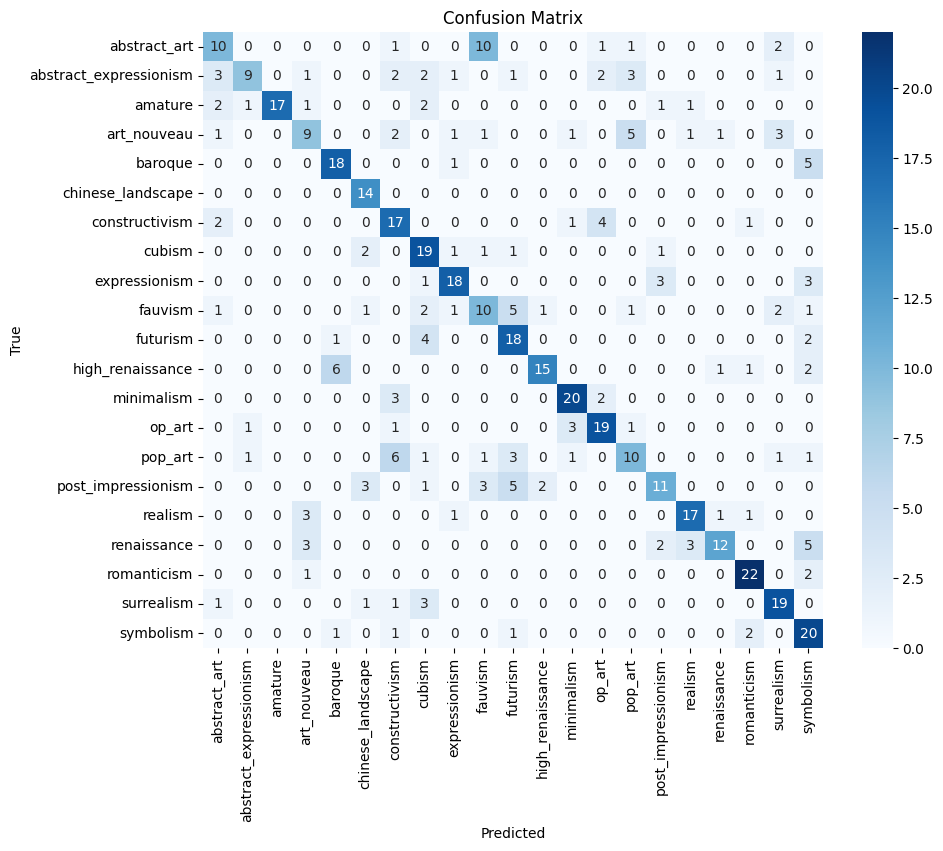

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm  # PVT v2 from timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define custom dataset
class CustomArtworkDataset(datasets.ImageFolder):
    def __getitem__(self, idx):
        path, class_idx = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Define PVT v2-based model
class ArtworkClassificationModel(nn.Module):
    def __init__(self, num_classes=21):
        super(ArtworkClassificationModel, self).__init__()
        # Load pretrained PVT v2 without classifier
        self.pvt_v2 = timm.create_model('pvt_v2_b2', pretrained=True, num_classes=0)

        # Get the feature dimension
        in_features = self.pvt_v2.num_features

        # Custom classifier
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        features = self.pvt_v2(x)
        out = self.fc(features)
        return out

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # PVT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Dataset paths
dataset_path = "/content/MerakiNexus-V2/art_classification_model/dataset"
train_data = CustomArtworkDataset(root=f"{dataset_path}/train", transform=transform)
val_data = CustomArtworkDataset(root=f"{dataset_path}/val", transform=transform)
test_data = CustomArtworkDataset(root=f"{dataset_path}/test", transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# Model, Loss, Optimizer
model = ArtworkClassificationModel(num_classes=len(train_data.classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 25
train_losses = []
val_accuracies = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training") as tepoch:
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            tepoch.set_postfix(loss=loss.item())

    train_accuracy = correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1} Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracy*100:.2f}% | Val Acc: {val_accuracy*100:.2f}%")

# Training time
total_time = time.time() - start_time
print(f"\nTotal Training Time: {total_time:.2f}s ({total_time/60:.2f}min)")

# Plot Loss and Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), val_accuracies, color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluation on Test Set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Accuracy & Report
accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_data.classes, yticklabels=train_data.classes, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [20]:
scripted_model = torch.jit.script(model)  # Convert to TorchScript

# Save the TorchScript model to a file
torch.jit.save(scripted_model, "/content/artwork_classification_model_pvt_v2.pth");